In [1]:
import pandas as pd

In [2]:
labelfile = './CowenKeltnerEmotionalVideos.csv'
labeldf = pd.read_csv(labelfile)

In [3]:
emocols= labeldf.columns[list(range(0,34))]
affectdimcols= labeldf.columns[list(range(34,48))]
freewordcols=labeldf.columns[list(range(48,648))]

In [4]:
sampletrain= labeldf.head(99).iloc[:89][emocols]
sampletest = labeldf.head(99).iloc[89:][emocols]

In [5]:
sampletrainindexed = sampletrain.set_index('Filename')
sampletestindexed = sampletest.set_index('Filename')

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.applications.vgg16 import VGG16
import cv2
import math
import os
from glob import glob
from scipy import stats as s

Using TensorFlow backend.
/home/yt/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yt/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yt/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yt/anaconda3/envs/tf_gpu/l

In [7]:
base_model = VGG16(weights='imagenet', include_top=False)

In [8]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(101, activation='softmax'))
# We have 21 classes 
model.add(Dense(33, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
# loading the trained weights
model.load_weights("./weight.hdf5")

In [10]:
# compiling the model
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
# getting the test list
f = open("traintestsplit/testlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# creating the dataframe
test = pd.DataFrame()
test['video_name'] = videos
test = test[:-1]
test_videos = test['video_name']
test.head()

,video_name
0,0090.mp4
1,0091.mp4
2,0092.mp4
3,0093.mp4
4,0094.mp4


In [12]:
test_videos.shape

(10,)

In [13]:
# creating tags for test videos
test_video_tag = []
for i in range(test.shape[0]):
    tag = sampletestindexed.loc[test['video_name'][i]].idxmax()
    test_video_tag.append(tag)
    
test['tag'] = test_video_tag

In [14]:
test.head()

,video_name,tag
0,0090.mp4,Aesthetic Appreciation
1,0091.mp4,Amusement
2,0092.mp4,Entrancement
3,0093.mp4,Surprise
4,0094.mp4,Amusement


In [15]:
# creating the tags
#train = pd.read_csv('Cowen/train_new.csv')
#y = train['class']
#y = pd.get_dummies(y)

In [16]:
!mkdir temp && ls

mkdir: cannot create directory ‘temp’: File exists


In [17]:
# creating two lists to store predicted and actual tags
predict = []
actual = []
test_y=pd.DataFrame()
# for loop to extract frames from each test video
#for i in tqdm(range(test_videos.shape[0])): 
for i in tqdm(range(10)): # memory constraints
    count = 0
    videoFile = test_videos[i]
    cap = cv2.VideoCapture('Videos/'+videoFile)   # capturing the video from the given path
    frameRate = cap.get(1) #frame rate
    x=1
    # removing all other files from the temp folder
    files = glob('temp/*')
    for f in files:
        os.remove(f)
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        #if (frameId % math.floor(frameRate) == 0):
            # storing the frames of this particular video in temp folder
        filename ='temp/' + "_frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
    cap.release()
    
    # reading all the frames from temp folder
    images = glob("temp/*.jpg")
    
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    # extracting features using pre-trained model
    prediction_images = base_model.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    #prediction = model.predict_classes(prediction_images)
    prediction = model.predict(prediction_images)
    
    # appending the mode of predictions in predict list to assign the tag to the video
    #predict.append(y.columns.values[s.mode(prediction)[0][0]])
    predict.append(prediction)
    # appending the actual tag of the video
    #actual.append(videoFile.split('/')[1].split('_')[1])
    actual.append( sampletestindexed.loc[videoFile].values)

100%|██████████| 10/10 [01:55<00:00, 11.53s/it]


In [34]:
actual

[array([0.     , 0.     , 0.55556, 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.55556, 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.     , 0.11111, 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.11111, 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.11111, 0.     , 0.     , 0.     ]),
 array([0.      , 0.      , 0.      , 0.38462 , 0.      , 0.      ,
        0.      , 0.30769 , 0.076923, 0.      , 0.30769 , 0.      ,
        0.      , 0.076923, 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.15385 , 0.15385 ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      ]),
 array([0.      , 0.      , 0.30769 , 0.076923, 0.      , 0.      ,
        0.23077 , 0.      , 0.15385 , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.38462 , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.30769 , 0.      ,
        0

In [18]:
[p.shape for p in predict]

[(10, 33),
 (250, 33),
 (100, 33),
 (80, 33),
 (60, 33),
 (75, 33),
 (66, 33),
 (42, 33),
 (375, 33),
 (31, 33)]

In [32]:

np.mean(predict[0],axis=0) - actual[0]

array([ 4.75645083e-06,  4.47034836e-07, -5.31556306e-01,  2.43907571e-02,
        0.00000000e+00,  0.00000000e+00,  4.59498823e-01,  2.98023228e-09,
        8.19265824e-06, -5.55559502e-01,  1.51991841e-07,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.11100162e-01,  0.00000000e+00,  2.06023152e-03,  9.53674331e-08,
        0.00000000e+00,  0.00000000e+00, -1.02666674e-01,  1.15364792e-05,
        0.00000000e+00,  3.87430177e-08,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.10097243e-01,  0.00000000e+00,  6.31982926e-04,
        8.05384985e-08])

In [27]:
pd.DataFrame(predict[0])

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.000006,5.662441e-07,0.024858,0.027535,0.0,0.0,0.463600,0.000000e+00,0.000010,6.258488e-07,...,0.000016,0.0,0.000000e+00,0.0,0.0,0.0,0.001156,0.0,0.000754,1.192093e-07
1,0.000003,4.172325e-07,0.022379,0.025451,0.0,0.0,0.460632,0.000000e+00,0.000007,3.576279e-07,...,0.000012,0.0,0.000000e+00,0.0,0.0,0.0,0.000859,0.0,0.000559,0.000000e+00
2,0.000006,5.662441e-07,0.024618,0.026263,0.0,0.0,0.464459,0.000000e+00,0.000009,6.258488e-07,...,0.000013,0.0,8.940697e-08,0.0,0.0,0.0,0.001158,0.0,0.000728,1.192093e-07
3,0.000002,2.086163e-07,0.022512,0.015711,0.0,0.0,0.467147,0.000000e+00,0.000004,2.384186e-07,...,0.000005,0.0,0.000000e+00,0.0,0.0,0.0,0.000626,0.0,0.000404,2.980232e-08
4,0.000007,5.364418e-07,0.025081,0.027372,0.0,0.0,0.456397,2.980232e-08,0.000010,6.854534e-07,...,0.000015,0.0,8.940697e-08,0.0,0.0,0.0,0.001184,0.0,0.000748,1.192093e-07
5,0.000004,3.874302e-07,0.024255,0.020677,0.0,0.0,0.451479,0.000000e+00,0.000008,5.364418e-07,...,0.000010,0.0,2.980232e-08,0.0,0.0,0.0,0.000970,0.0,0.000610,1.192093e-07
6,0.000007,6.258488e-07,0.018749,0.031462,0.0,0.0,0.452948,0.000000e+00,0.000010,4.768372e-07,...,0.000017,0.0,8.940697e-08,0.0,0.0,0.0,0.001318,0.0,0.000742,1.490116e-07
7,0.000005,3.874302e-07,0.022762,0.022505,0.0,0.0,0.459348,0.000000e+00,0.000008,4.768372e-07,...,0.000010,0.0,5.960464e-08,0.0,0.0,0.0,0.001024,0.0,0.000625,0.000000e+00
8,0.000004,4.172325e-07,0.022551,0.025447,0.0,0.0,0.450955,0.000000e+00,0.000008,3.874302e-07,...,0.000009,0.0,0.000000e+00,0.0,0.0,0.0,0.000974,0.0,0.000573,5.960464e-08
9,0.000003,3.576279e-07,0.032271,0.021484,0.0,0.0,0.468022,0.000000e+00,0.000008,5.662441e-07,...,0.000008,0.0,2.980232e-08,0.0,0.0,0.0,0.000858,0.0,0.000577,9.012924e-08


In [20]:
pd.DataFrame(actual[0]).transpose()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.55556,0.0,0.0,0.0,0.0,0.0,0.0,0.55556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.11111,0.0,0.0,0.0


In [35]:
s.mode?

In [40]:
# checking the accuracy of the predicted tags
from sklearn.metrics import accuracy_score
#accuracy_score(predict, actual)*100

In [83]:
def plot_a(i):
    plt.plot(actual[i])
    
def plot_p(i):
    plt.plot(np.transpose(predict[i]))
    
def plot_diff(i):
    plt.scatter(range(0,len(actual[i])),np.mean(predict[i],axis=0)- actual[i])

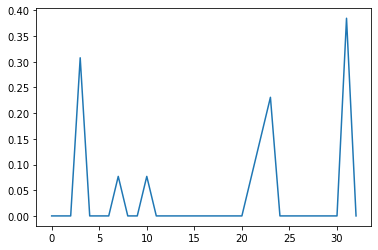

In [93]:
plot_a(3)


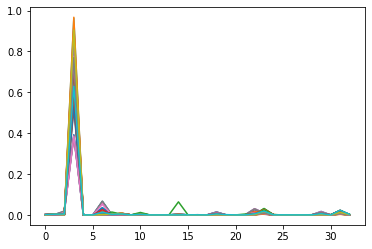

In [94]:
plot_p(3)

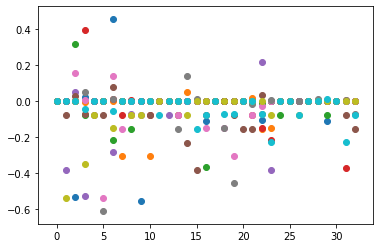

In [80]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(0,len(actual)):
    plt.scatter(range(0,len(actual[i])),np.mean(predict[i],axis=0)- actual[i])

In [ ]:
plot_diff(0)